In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import torch
import torch.nn as nn

Change working directory

In [2]:
notebook_path = %pwd

os.chdir(Path(notebook_path).parent)
os.getcwd()

'/home/atleeri/repositories/forecast-electricity-markets'

Load processed data

In [3]:
processed_data_dir = Path('data/processed')
filepaths = list(processed_data_dir.glob('**/*60*.parquet'))
filepaths

[PosixPath('data/processed/opsd-time_series-2020-10-06/time_series_60min_singleindex.parquet')]

In [4]:
filepath = filepaths[0]
df = pd.read_parquet(filepath)
df

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,8852.0,NaN
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,9054.0,NaN
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,9070.0,NaN
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,9163.0,NaN
...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30 20:00:00+01:00,10654.0,49.92
50397,2020-09-30 20:00:00+00:00,2020-09-30 21:00:00+01:00,11836.0,42.79
50398,2020-09-30 21:00:00+00:00,2020-09-30 22:00:00+01:00,12168.0,35.02
50399,2020-09-30 22:00:00+00:00,2020-09-30 23:00:00+01:00,12533.0,34.40


In [5]:
df.columns

Index(['utc_timestamp', 'cet_cest_timestamp', 'DE_wind_generation',
       'DE_price_ahead'],
      dtype='object')

In [6]:
df_sample = df.sample(n=len(df), random_state=2025)

In [7]:
df_sample

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
20095,2017-04-17 06:00:00+00:00,2017-04-17 07:00:00+01:00,6150.0,NaN
47699,2020-06-10 10:00:00+00:00,2020-06-10 11:00:00+01:00,3769.0,34.90
48713,2020-07-22 16:00:00+00:00,2020-07-22 17:00:00+01:00,3007.0,42.19
46775,2020-05-02 22:00:00+00:00,2020-05-02 23:00:00+01:00,12000.0,18.00
18157,2017-01-26 12:00:00+00:00,2017-01-26 13:00:00+01:00,9436.0,NaN
...,...,...,...,...
15948,2016-10-26 11:00:00+00:00,2016-10-26 12:00:00+01:00,1797.0,NaN
11102,2016-04-07 13:00:00+00:00,2016-04-07 14:00:00+01:00,17177.0,NaN
16338,2016-11-11 17:00:00+00:00,2016-11-11 18:00:00+01:00,3593.0,NaN
32478,2018-09-15 05:00:00+00:00,2018-09-15 06:00:00+01:00,13707.0,NaN


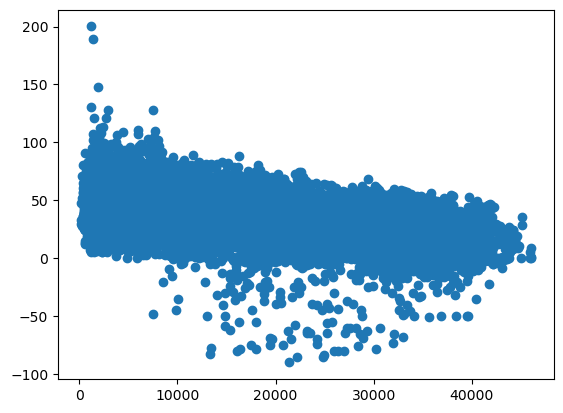

In [8]:
valid_mask = df_sample['DE_wind_generation'].notna() & df_sample['DE_price_ahead'].notna()
plt.scatter(df_sample[valid_mask]['DE_wind_generation'], df_sample[valid_mask]['DE_price_ahead'])

#### Forecast using only price data

In [34]:
data = df_sample[valid_mask]['DE_price_ahead'].sort_index().values
data.shape

(17540,)

In [64]:
data.shape[0] % 20

0

In [36]:
data[np.min([i+seq_len, len(data)]).item()]

np.float64(44.75)

Create sequences

In [67]:
seq_len= 20

X, y = np.empty((len(data) - seq_len, seq_len)), np.empty((len(data) - seq_len))
for i in range(len(data) - seq_len):
    X[i] = data[i:i+seq_len]
    y[i] = data[np.min([i+seq_len, len(data)]).item()]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [69]:
y.shape, X.shape

(torch.Size([17520]), torch.Size([17520, 20]))

Split into train, validation and test data

In [77]:
X_train, X_val, X_test = torch.split(X, [int(0.7*len(X)), int(0.15*len(X)), int(0.15*len(X))])
y_train, y_val, y_test = torch.split(y, [int(0.7*len(y)), int(0.15*len(y)), int(0.15*len(y))])

# add dim to X_train
X_train = X_train.unsqueeze(dim=-1)

In [78]:
X_train.shape

torch.Size([12264, 20, 1])

Define Model

In [111]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        out, _ = self.rnn(x)
        pred = self.fc(out[:,-1,:])
        return pred

Train

In [113]:
model = Model()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

losses = []
for epoch in range(50):
    optimizer.zero_grad()

    prediction = model.forward(X_train)

    loss = criterion(prediction.squeeze(), y_train)

    losses.append(loss.item())

    loss.backward()

    optimizer.step()

In [114]:
prediction.shape

torch.Size([12264, 1])

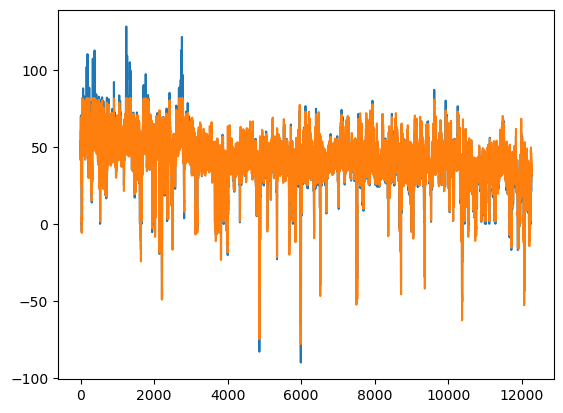

In [115]:
plt.plot(y_train)
plt.plot(prediction[:,0].detach().numpy())

Test

In [119]:
X_test = X_test.unsqueeze(-1)

MSE = 430.79


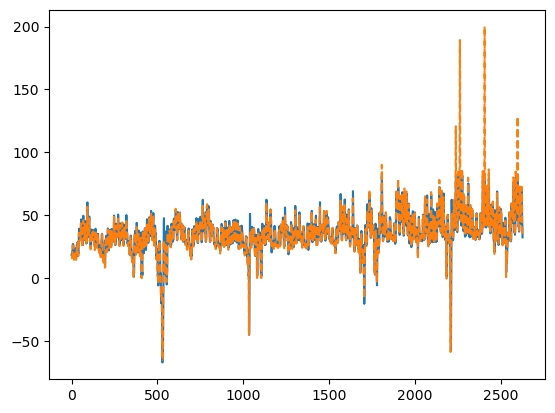

In [125]:
with torch.no_grad():
    prediction = model(X_test)

    plt.plot(prediction)
    plt.plot(y_test, '--')

    mse = ((prediction-y_test)**2).mean()
    print(f'MSE = {mse:.2f}')